In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from original_models import *

from optimization import *
torch.set_default_dtype(torch.float64)

['/home/rdoz/miniconda3/envs/myenv/lib/python313.zip', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/lib-dynload', '', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages', '/home/rdoz/PhD/DeGAS/src']


/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


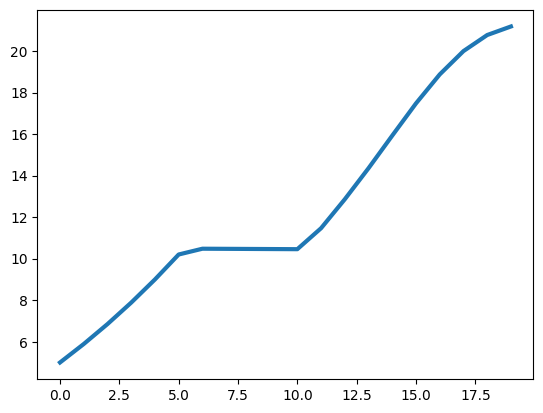

In [2]:
soga_code = """
array[21] v;

w = 0;             
gear = 1;           
currV = 5;         

for i in range(21) {

    v[i] = currV;          

    if gear > 0.5 {
        newV = 1.078*currV + 0.1*gauss(5., 1.);
    } else {
        newV = currV*currV;
        newV = 0.00005*newV;
        newV = currV - newV + gauss(0, 1.);
    } end if;

    currV = newV;         

    if gear > 0.5 {
        if gear < 1.5 {
            if newV > _s1 {
                nxt = gear + 1;     
                gear = 0;               
                w = 0.3;               
            } else {
                skip;
            } end if;
        } else {
            if gear < 2.5 {
                if newV > _s2 {
                    nxt = gear + 1;  
                    gear = 0;             
                    w = 0.3;               
                } else {
                    skip;
                } end if;
            } else {
                skip;
            } end if;
        } end if;
    } else {
        if w < 0.05 {
            gear = nxt;             
        } else {
            skip;
        } end if;
    } end if;

    w = w - 0.1;

    v[i] = v[i] + gauss(0., 0.5);

} end for;
                    
"""
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s1':10., 's2':20.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:20].detach()
plt.plot(range(20), y_init, lw=3, label='SOGA w true params')

In [3]:
y = []
y_var = []
for i in range(20):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('v['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('v['+ str(i) +']'), output_dist.var_list.index('v['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('gearbox2_init.csv', index=False)

In [4]:
indexes = [i for i in range(21)]
loss = lambda dist : dist.gm.marg_cdf(torch.tensor([16.]), idx=indexes)
loss(output_dist)

/home/rdoz/PhD/DeGAS/src/libSOGAshared.py:209: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  bounds = torch.stack([torch.tensor([[-torch.inf, x[i, j] - mean[j]] for j in range(dim)]) for i in range(batch_size)])


tensor([[1.0000]], grad_fn=<MmBackward0>)

s1: 9.503362557885538 s2: 19.502086482421024  loss: 0.9999956440234924
s1: 9.0685472764895 s2: 19.005989390807247  loss: 0.9999938874571441
s1: 8.669860383996433 s2: 18.515059759697042  loss: 0.9999907540266055
s1: 8.26111374606659 s2: 18.031077244639775  loss: 0.9999859754355589
s1: 7.844759569137865 s2: 17.547984056784124  loss: 0.9999815917810717
s1: 7.472061218489355 s2: 17.070737509802306  loss: 0.9999717585638397
s1: 7.123445346931864 s2: 16.596050553308835  loss: 0.999960637521058
s1: 6.740452777384503 s2: 16.11857946157374  loss: 0.9999499909541835
s1: 6.36633766326223 s2: 15.64461345275592  loss: 0.9999229355451835
s1: 6.030922755360221 s2: 15.168297240299333  loss: 0.9998996393905585
s1: 5.655744256151372 s2: 14.686613563406466  loss: 0.9998728623706463
s1: 5.287498418536903 s2: 14.206162411145812  loss: 0.9998049583100396
s1: 4.955530673796709 s2: 13.71960280959693  loss: 0.9997607230531288
s1: 4.655630801972345 s2: 13.224938614523873  loss: 0.9997061604106869
s1: 4.38423309

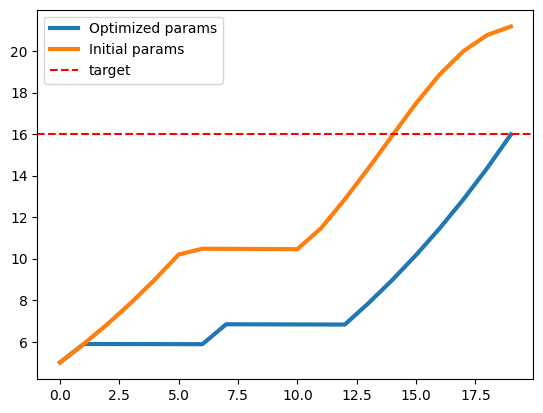

In [5]:
params_dict = initialize_params(params)
T = 20
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=40, lr=0.5)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_opt = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_opt, lw=3, label='Optimized params')
plt.plot(range(T), y_init, lw=3, label='Initial params')
#add horizontal line at y=20
plt.axhline(y=16, color='r', linestyle='--', label='target')
plt.legend()

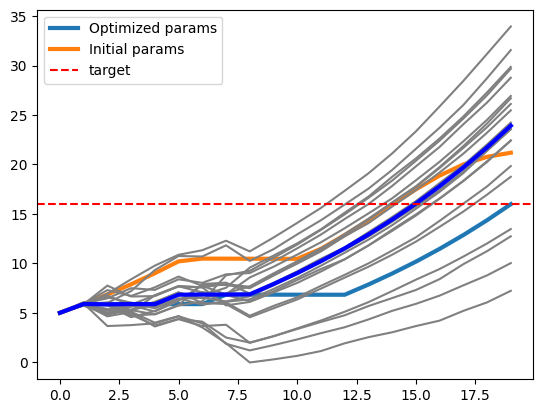

In [16]:
orig_params, n_traj, params, var_name, model, n_steps, lr = get_orig_params('gearbox')
orig_params['s1'] = 1.91633541111376
orig_params['s2'] = -1.5659851955264432
orig_traj, other = generate_traj(model, n_traj, orig_params)
plt.plot(range(T), y_opt, lw=3, label='Optimized params')
plt.plot(range(T), y_init, lw=3, label='Initial params')
#plot all the trajectories
plot_traj_set(orig_traj, single_traj=20)
plt.axhline(y=16, color='r', linestyle='--', label='target')
plt.legend()

In [17]:
# for each trajectory, check that it always remains below y=16
counter = 0
for i in range(n_traj):
    traj = orig_traj[i]
    if all(traj[j] <= 16 for j in range(20)):
        counter += 1

print(f"Number of safe trajectories (always below y=16): {counter} out of {n_traj}")

Number of safe trajectories (always below y=16): 72 out of 1000


In [ ]:
y = []
y_var = []
for i in range(T):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('v['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('v['+ str(i) +']'), output_dist.var_list.index('v['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('gearbox2_opt.csv', index=False)

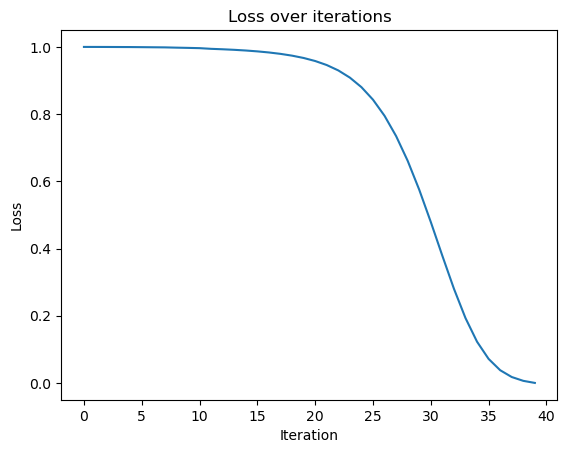

In [ ]:
# export loss_list to csv
#normalize loss_list
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('gearbox2_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()